In [1]:
import sys
from pathlib import Path

project_root = Path("../")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import os
from typing import List, TypedDict, Literal, Dict, Any
from datetime import datetime

from dotenv import load_dotenv

env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    print(f".env 파일 로드 완료: {env_path}")
else:
    print(f".env 파일을 찾을 수 없습니다: {env_path}")

import requests
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.documents import Document
from langchain_core.tools import StructuredTool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated

from src.utils import load_vectorstore, load_llm
from src.storage import Storage

try:
    from tavily import TavilyClient
    TAVILY_AVAILABLE = True
except ImportError:
    TAVILY_AVAILABLE = False
    print("tavily-python이 설치되지 않았습니다. 웹 검색 기능을 사용하려면 설치해주세요: pip install tavily-python")

try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
except ImportError:
    YFINANCE_AVAILABLE = False
    print("yfinance가 설치되지 않았습니다. 주식 기능을 사용하려면 설치해주세요: pip install yfinance")


.env 파일 로드 완료: ../.env


/Users/user/Documents/study/learning_langchain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
db_path = "../data/db"
storage_path = "../data/processed"

print("벡터 저장소 로드 중...")
vectorstore = load_vectorstore(db_path)
print("벡터 저장소 로드 완료")

print("\nRetriever 초기화 중...")
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
print("Retriever 초기화 완료")

print("\nStorage 초기화 중...")
storage = Storage(storage_path)
print("Storage 초기화 완료")

print("\nLLM 초기화 중...")
llm = load_llm()
if llm:
    print("LLM 초기화 완료")
else:
    print("LLM 초기화 실패 (GPT_API_KEY 확인 필요)")

tavily_client = None
if TAVILY_AVAILABLE:
    tavily_api_key = os.getenv("TAVILY_API_KEY")
    if tavily_api_key:
        tavily_client = TavilyClient(api_key=tavily_api_key)
        print("\nTavily 클라이언트 초기화 완료")
    else:
        print("\nTAVILY_API_KEY가 설정되지 않았습니다. 웹 검색 기능이 제한됩니다.")

openweather_api_key = os.getenv("OPENWEATHER_API_KEY")
if openweather_api_key:
    print("\nOpenWeatherMap API 키 설정 완료")
else:
    print("\nOPENWEATHER_API_KEY가 설정되지 않았습니다. 날씨 기능이 제한됩니다.")


벡터 저장소 로드 중...


/Users/user/Documents/study/learning_langchain/weekly_project/../src/utils.py:30: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


벡터 저장소 로드 완료

Retriever 초기화 중...
Retriever 초기화 완료

Storage 초기화 중...
Storage 초기화 완료

LLM 초기화 중...
LLM 초기화 완료

Tavily 클라이언트 초기화 완료

OpenWeatherMap API 키 설정 완료


In [3]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    query: str
    intent: str
    context: str
    iteration_count: int
    max_iterations: int
    final_answer: str
    intent_history: List[str]


In [4]:
def retrieve_documents(query: str, k: int = 5) -> List[Document]:
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    return retriever.invoke(query)

def load_original_content(doc: Document) -> str:
    doc_type = doc.metadata.get('type', 'text')
    
    if doc_type == 'table':
        table_id = doc.metadata.get('table_id')
        if table_id:
            table_data = storage.get_table(table_id)
            if table_data:
                markdown = table_data.get('markdown', '')
                description = table_data.get('description', '')
                return f"{description}\n{markdown}" if description else markdown
    else:
        chunk_id = doc.metadata.get('chunk_id')
        text_id = doc.metadata.get('text_id') or f'text_{chunk_id}' if chunk_id is not None else None
        
        if text_id:
            text_data = storage.get_text(text_id)
            if text_data:
                return text_data.get('original_text', doc.page_content)
    
    return doc.page_content

def build_context(docs: List[Document]) -> str:
    context_parts = []
    for i, doc in enumerate(docs, 1):
        original_content = load_original_content(doc)
        doc_type = doc.metadata.get('type', 'text')
        
        if doc_type == 'table':
            table_id = doc.metadata.get('table_id', '')
            context_parts.append(f"[테이블 {i}: {table_id}]\n{original_content}")
        else:
            context_parts.append(f"[텍스트 {i}]\n{original_content}")
    
    return "\n\n".join(context_parts)


In [5]:
class CalculatorInput(BaseModel):
    expression: str = Field(description="계산할 수식 (예: 14598 - 5653)")

class WebSearchInput(BaseModel):
    query: str = Field(description="검색할 쿼리")

class WeatherInput(BaseModel):
    city: str = Field(description="날씨를 조회할 도시 이름")

class StockPriceInput(BaseModel):
    symbol: str = Field(description="주식 심볼 (예: TSLA, AAPL, 005930)")

class DocumentSearchInput(BaseModel):
    query: str = Field(description="문서에서 검색할 쿼리")

class GraphVisualizationInput(BaseModel):
    data: Dict[str, Any] = Field(description="그래프 데이터 (x, y 리스트 포함)")
    chart_type: str = Field(default="line", description="차트 타입 (line, bar, scatter)")

def calculator_func(expression: str) -> str:
    try:
        allowed_chars = set('0123456789+-*/()., ')
        if not all(c in allowed_chars for c in expression):
            return f"오류: 허용되지 않은 문자가 포함되어 있습니다."
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"오류: {str(e)}"

def web_search_func(query: str) -> str:
    if not tavily_client:
        return "오류: Tavily 클라이언트가 초기화되지 않았습니다."
    
    try:
        response = tavily_client.search(query=query, max_results=5)
        results = []
        for item in response.get('results', []):
            results.append(f"제목: {item.get('title', '')}\nURL: {item.get('url', '')}\n내용: {item.get('content', '')}")
        return "\n\n".join(results) if results else "검색 결과가 없습니다."
    except Exception as e:
        return f"오류: {str(e)}"

def weather_func(city: str) -> str:
    api_key = os.getenv("OPENWEATHER_API_KEY")
    if not api_key:
        return "오류: OpenWeatherMap API 키가 설정되지 않았습니다."
    
    try:
        url = f"http://api.openweathermap.org/data/2.5/weather"
        params = {
            "q": city,
            "appid": api_key,
            "units": "metric",
            "lang": "kr"
        }
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        result = f"""도시: {data.get('name', city)}
온도: {data.get('main', {}).get('temp')}°C
설명: {data.get('weather', [{}])[0].get('description', '')}
습도: {data.get('main', {}).get('humidity')}%
풍속: {data.get('wind', {}).get('speed')} m/s"""
        return result
    except Exception as e:
        return f"오류: {str(e)}"

def stock_price_func(symbol: str) -> str:
    if not YFINANCE_AVAILABLE:
        return "오류: yfinance가 설치되지 않았습니다."
    
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        
        current_price = info.get('currentPrice') or info.get('regularMarketPrice')
        previous_close = info.get('previousClose')
        change = current_price - previous_close if current_price and previous_close else None
        
        result = f"""심볼: {symbol.upper()}
회사명: {info.get('longName') or info.get('shortName', '')}
현재가(오늘): {current_price}
전일 종가(어제): {previous_close}
변동액: {change}
시가총액: {info.get('marketCap')}
거래량: {info.get('volume')}
통화: {info.get('currency', 'USD')}

참고: 변화율 계산이 필요하면 calculator 도구를 사용하여 "(현재가 - 전일종가) / 전일종가 * 100" 형식으로 계산하세요."""
        return result
    except Exception as e:
        return f"오류: {str(e)}"

def document_search_func(query: str) -> str:
    docs = retrieve_documents(query, k=5)
    context = build_context(docs)
    return context

def graph_visualization_func(data: Dict[str, Any], chart_type: str = "line") -> str:
    try:
        if "x" not in data or "y" not in data:
            return "오류: 데이터에 'x'와 'y' 키가 필요합니다."
        
        plt.figure(figsize=(10, 6))
        
        if chart_type == "line":
            plt.plot(data["x"], data["y"], marker='o')
        elif chart_type == "bar":
            plt.bar(data["x"], data["y"])
        elif chart_type == "scatter":
            plt.scatter(data["x"], data["y"])
        else:
            plt.plot(data["x"], data["y"], marker='o')
        
        if "title" in data:
            plt.title(data["title"])
        if "xlabel" in data:
            plt.xlabel(data["xlabel"])
        if "ylabel" in data:
            plt.ylabel(data["ylabel"])
        
        plt.grid(True)
        
        output_dir = Path("../output")
        output_dir.mkdir(exist_ok=True)
        filename = f"chart_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        filepath = output_dir / filename
        plt.savefig(filepath)
        plt.close()
        
        return f"그래프가 생성되었습니다: {filepath}"
    except Exception as e:
        return f"오류: {str(e)}"

calculator = StructuredTool.from_function(
    func=calculator_func,
    name="calculator",
    description="수식 계산 도구. 수식을 입력하면 결과를 반환합니다. 주가 변화율, 차이, 비율 등을 계산할 때 사용하세요. 예: '14598 - 5653', '(245.50 - 240.00) / 240.00 * 100' (변화율 계산)",
    args_schema=CalculatorInput
)

web_search = StructuredTool.from_function(
    func=web_search_func,
    name="web_search",
    description="웹 검색 도구. 주식 뉴스, 일반 정보 등을 검색합니다.",
    args_schema=WebSearchInput
)

weather = StructuredTool.from_function(
    func=weather_func,
    name="weather",
    description="날씨 정보 조회 도구. 도시 이름을 입력하면 현재 날씨를 반환합니다.",
    args_schema=WeatherInput
)

stock_price = StructuredTool.from_function(
    func=stock_price_func,
    name="stock_price",
    description="주식 현재 주가 조회 도구. 주식 심볼(예: TSLA, AAPL, 005930)을 입력하면 현재 주가, 전일 종가 등을 반환합니다. 주가 관련 질문(현재 주가, 주가 변화, 주가 비교 등)이면 반드시 이 도구를 사용하세요. 변화율 계산이 필요한 경우 calculator 도구를 추가로 사용하세요.",
    args_schema=StockPriceInput
)

document_search = StructuredTool.from_function(
    func=document_search_func,
    name="document_search",
    description="문서 검색 도구. 벡터 저장소에서 관련 문서를 검색합니다. 주의: 주가, 주식 가격, 주가 변화 등 주가 관련 질문은 이 도구를 사용하지 말고 stock_price 도구를 사용하세요. 문서에서 정보를 찾을 수 없거나 부족한 경우, stock_price(주가 정보)나 web_search(웹 검색) 도구를 추가로 사용하세요.",
    args_schema=DocumentSearchInput
)

graph_visualization = StructuredTool.from_function(
    func=graph_visualization_func,
    name="graph_visualization",
    description="그래프 시각화 도구. 데이터를 입력하면 차트를 생성합니다. data는 x, y 리스트를 포함한 딕셔너리여야 합니다.",
    args_schema=GraphVisualizationInput
)

tools = [calculator, web_search, weather, stock_price, document_search, graph_visualization]

try:
    if 'llm' in globals() and llm:
        model_with_tools = llm.bind_tools(tools)
    else:
        model_with_tools = None
        print("경고: llm이 정의되지 않았습니다.")
except NameError:
    model_with_tools = None
    print("경고: llm이 정의되지 않았습니다.")


In [6]:
def classify_intent(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    
    if not llm:
        state["intent"] = "SMALL_TALK"
        return state
    
    prompt = f"""다음 사용자 발화를 보고, 의도를 아래 중 하나로 골라라: DOC_QA, SUMMARY, SMALL_TALK. 다른 말은 하지 말고, 태그만 출력해라.

의도 설명:
- DOC_QA: 문서나 데이터에 대한 질문 (예: "테슬라 매출은?", "중국 대비 미국 차이", "주가 알려줘")
- SUMMARY: 이전 대화나 정보의 요약 요청 (예: "요약해줘", "정리해줘", "핵심만")
- SMALL_TALK: 인사나 일반적인 대화 (예: "안녕", "뭐야", "누구야")

사용자 발화: {query}

의도:"""
    
    try:
        response = llm.invoke(prompt)
        intent = response.content.strip() if hasattr(response, 'content') else str(response).strip()
        
        if intent not in ["DOC_QA", "SUMMARY", "SMALL_TALK"]:
            if any(keyword in query.lower() for keyword in ["요약", "정리", "핵심", "요점"]):
                intent = "SUMMARY"
            elif any(keyword in query.lower() for keyword in ["안녕", "뭐야", "누구", "소개", "날씨", "기온", "온도", "비", "눈", "맑음", "흐림"]):
                intent = "SMALL_TALK"
            else:
                intent = "DOC_QA"
        
        # 주가/재무 관련 키워드가 있으면 DOC_QA로 분류
        doc_qa_keywords = [
            "주가", "주식", "가격", "변화", "상승", "하락", "증가", "감소", "변동", "차이", "비교",
            "매출", "실적", "수익", "영업", "이익", "손익", "재무", "재무제표", "분기", "연간",
            "TSLA", "AAPL", "005930", "테슬라", "애플", "삼성",
            "미국", "중국", "지역", "지리", "국가별"
        ]
        if any(keyword in query for keyword in doc_qa_keywords):
            intent = "DOC_QA"
        
        weather_keywords = ["날씨", "기온", "온도", "비", "눈", "맑음", "흐림", "바람", "습도", "강수"]
        if any(keyword in query for keyword in weather_keywords):
            intent = "SMALL_TALK"
        
        state["intent"] = intent
    except Exception as e:
        print(f"의도 분류 오류: {e}")
        state["intent"] = "SMALL_TALK"
    
    return state




In [8]:
def model_node(state: AgentState) -> AgentState:
    if not model_with_tools:
        state["messages"].append(AIMessage(content="LLM이 설정되지 않아 답변을 생성할 수 없습니다."))
        return state
    
    query = state.get("query", "")
    messages = state.get("messages", [])
    
    # 현재 질문과 관련된 메시지만 필터링
    # SystemMessage는 유지하고, 현재 질문의 HumanMessage부터 시작
    filtered_messages = []
    current_query_found = False
    
    for msg in messages:
        # SystemMessage는 항상 포함
        if isinstance(msg, SystemMessage):
            filtered_messages.append(msg)
        elif isinstance(msg, HumanMessage) and msg.content == query:
            current_query_found = True
            filtered_messages.append(msg)
        elif current_query_found:
            # 현재 질문 이후의 메시지만 포함
            filtered_messages.append(msg)
    
    # 현재 질문이 없으면 모든 메시지 사용 (첫 질문인 경우)
    if not current_query_found:
        filtered_messages = messages
    
    res = model_with_tools.invoke(filtered_messages)
    return {"messages": [res]}

def should_continue_tools(state: AgentState) -> Literal["tools", "continue", "end", "check_document"]:
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    if isinstance(last_message, AIMessage):
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            tool_names = [tc.get('name') for tc in last_message.tool_calls]
            if 'document_search' in tool_names:
                return "check_document"
            return "tools"
        else:
            return "continue"
    
    return "end"

def check_document_result_node(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    intent = state.get("intent", "DOC_QA")
    
    print(f"[DEBUG] check_document_result_node: 실행 시작")
    print(f"[DEBUG] check_document_result_node: query={query}, intent={intent}, messages 개수={len(messages)}")
    
    if intent != "DOC_QA":
        print(f"[DEBUG] check_document_result_node: DOC_QA가 아니므로 스킵")
        return state
    
    document_search_result = None
    
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage) and msg.name == "document_search":
            document_search_result = msg.content
            print(f"[DEBUG] check_document_result_node: document_search ToolMessage 결과 발견, 길이={len(document_search_result)}자")
            break
    
    if not document_search_result:
        document_search_result = state.get("context", "")
        if document_search_result:
            print(f"[DEBUG] check_document_result_node: document_search state 결과 발견, 길이={len(document_search_result)}자")
    
    if not document_search_result or document_search_result.strip() == "문서 검색 결과가 없습니다.":
        stock_keywords = ["주가", "주식", "가격", "변화", "상승", "하락", "증가", "감소", "변동", "차이", "비교", "저번주", "이번주", "어제", "오늘", "전일", "현재가"]
        is_stock_query = any(keyword in query for keyword in stock_keywords)
        
        if is_stock_query:
            system_msg = SystemMessage(content="""문서 검색 결과가 없습니다. 주가 관련 질문이므로 stock_price 도구를 사용하세요.""")
        else:
            system_msg = SystemMessage(content="""문서 검색 결과가 없습니다. web_search 도구를 사용하여 최신 정보를 검색하세요.""")
        
        messages.append(system_msg)
        state["messages"] = messages
        return state
    
    stock_keywords = ["주가", "주식", "가격", "변화", "상승", "하락", "증가", "감소", "변동", "차이", "비교", "저번주", "이번주", "어제", "오늘", "전일", "현재가"]
    is_stock_query = any(keyword in query for keyword in stock_keywords)
    
    if is_stock_query:
        return state
    
    if not llm:
        return state
    
    prompt = f"""다음은 document_search 도구의 실행 결과입니다.

사용자 질문: {query}

문서 검색 결과:
{document_search_result[:1500]}

위 문서 검색 결과만으로 사용자 질문에 충분히 답변할 수 있는지 판단하세요.
다음 형식으로 답변하세요:
- 충분하면: "충분: [이유]"
- 부족하면: "부족: [이유]"

답변:"""
    
    try:
        print(f"[DEBUG] check_document_result_node: 문서 검색 결과 충분성 판단 중...")
        print(f"[DEBUG] check_document_result_node: 사용자 질문: {query}")
        print(f"[DEBUG] check_document_result_node: 문서 검색 결과 길이: {len(document_search_result)}자")
        response = llm.invoke(prompt)
        judgment = response.content.strip() if hasattr(response, 'content') else str(response).strip()
        print(f"[DEBUG] check_document_result_node: LLM 판단 결과: {judgment}")
        
        # 판단 이유 추출
        if ":" in judgment:
            judgment_parts = judgment.split(":", 1)
            judgment_result = judgment_parts[0].strip()
            judgment_reason = judgment_parts[1].strip() if len(judgment_parts) > 1 else ""
            print(f"[DEBUG] check_document_result_node: 판단: {judgment_result}")
            if judgment_reason:
                print(f"[DEBUG] check_document_result_node: 판단 이유: {judgment_reason}")
        else:
            judgment_result = judgment
            judgment_reason = ""
        
        if "부족" in judgment_result or "불충분" in judgment_result or "없음" in judgment_result.lower():
            print(f"[DEBUG] check_document_result_node: 결과 부족 판단 -> web_search 사용 안내 추가")
            if judgment_reason:
                print(f"[DEBUG] check_document_result_node: 부족한 이유: {judgment_reason}")
            system_msg = SystemMessage(content="""문서 검색 결과가 부족합니다. web_search 도구를 사용하여 최신 정보를 검색하세요.""")
            messages.append(system_msg)
            state["messages"] = messages
        else:
            print(f"[DEBUG] check_document_result_node: 결과 충분 판단 -> 추가 도구 불필요")
            if judgment_reason:
                print(f"[DEBUG] check_document_result_node: 충분한 이유: {judgment_reason}")
    except Exception as e:
        print(f"[DEBUG] check_document_result_node: 문서 결과 검증 오류: {e}")
    
    return state

def doc_qa_node(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    intent = state.get("intent", "DOC_QA")
    
    print(f"[DEBUG] doc_qa_node: 실행 시작")
    print(f"[DEBUG] doc_qa_node: query={query}, intent={intent}, messages 개수={len(messages)}")
    
    # 현재 질문과 관련 없는 이전 메시지 필터링
    # 현재 질문의 HumanMessage만 찾아서 그 이후의 메시지만 사용
    filtered_messages = []
    current_query_found = False
    for msg in messages:
        if isinstance(msg, HumanMessage) and msg.content == query:
            current_query_found = True
            filtered_messages = []  # 현재 질문부터 시작
        if current_query_found:
            filtered_messages.append(msg)
    
    # 현재 질문이 없으면 모든 메시지 사용 (첫 질문인 경우)
    if not current_query_found:
        filtered_messages = messages
    
    # 현재 질문과 관련된 document_search나 context만 확인
    has_document_search = any(isinstance(msg, ToolMessage) and msg.name == "document_search" for msg in filtered_messages)
    has_context = bool(state.get("context", ""))
    
    if not has_document_search and not has_context:
        stock_keywords = ["주가", "주식", "가격", "변화", "상승", "하락", "증가", "감소", "변동", "차이", "비교", "저번주", "이번주", "어제", "오늘", "전일", "현재가"]
        is_stock_query = any(keyword in query for keyword in stock_keywords)
        
        if is_stock_query:
            print(f"[DEBUG] doc_qa_node: 주가 관련 질문으로 판단 -> stock_price 사용 안내")
            system_msg = SystemMessage(content="""주가 관련 질문입니다. stock_price 도구를 사용하여 주가 정보를 조회하세요.""")
            filtered_messages.append(system_msg)
            filtered_messages.append(HumanMessage(content=query))
        else:
            print(f"[DEBUG] doc_qa_node: document_search 실행")
            print(f"[DEBUG] doc_qa_node: 검색 쿼리: {query}")
            document_search_result = document_search_func(query)
            result_length = len(document_search_result) if document_search_result else 0
            print(f"[DEBUG] doc_qa_node: document_search 결과 길이: {result_length}자")
            if document_search_result:
                preview = document_search_result[:200].replace('\n', ' ')
                print(f"[DEBUG] doc_qa_node: 결과 미리보기: {preview}...")
            else:
                print(f"[DEBUG] doc_qa_node: 결과 없음")
            
            if document_search_result:
                state["context"] = document_search_result
                system_msg = SystemMessage(content=f"""document_search 도구가 실행되었습니다. 결과는 아래와 같습니다:

{document_search_result[:2000]}

이 결과를 먼저 확인하고 사용하세요.""")
                filtered_messages.append(system_msg)
            
            filtered_messages.append(HumanMessage(content=query))
        
        state["messages"] = filtered_messages
    else:
        print(f"[DEBUG] doc_qa_node: 이미 document_search 결과가 있음, 스킵")
        # 이미 결과가 있어도 필터링된 메시지만 사용
        state["messages"] = filtered_messages
    
    print(f"[DEBUG] doc_qa_node: 실행 완료, messages 개수={len(state.get('messages', []))}")
    return state


In [9]:
def small_talk_node(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    intent_history = state.get("intent_history", [])
    
    weather_keywords = ["날씨", "기온", "온도", "비", "눈", "맑음", "흐림", "바람", "습도", "강수"]
    is_weather_query = any(keyword in query for keyword in weather_keywords)
    
    if is_weather_query and model_with_tools:
        # 날씨 질문일 때는 이전 대화 기록을 무시하고 새로운 컨텍스트로 시작
        # model 노드로 가서 tool을 호출하도록 메시지만 준비
        fresh_messages = []
        system_msg = SystemMessage(content="""날씨 관련 질문입니다. weather 도구를 사용하여 날씨 정보를 조회하세요.""")
        fresh_messages.append(system_msg)
        fresh_messages.append(HumanMessage(content=query))
        state["messages"] = fresh_messages
        return state
    
    if not llm:
        answer = "안녕하세요! 저는 기술 문서를 기반으로 질문에 답변하는 AI 어시스턴트입니다."
    else:
        # 현재 질문과 관련된 메시지만 사용 (날씨 질문이 아닌 경우)
        filtered_messages = []
        current_query_found = False
        for msg in messages:
            if isinstance(msg, HumanMessage) and msg.content == query:
                current_query_found = True
                filtered_messages = []
            if current_query_found:
                filtered_messages.append(msg)
        
        if not current_query_found:
            filtered_messages = messages
        
        chat_history = "\n".join([f"{'사용자' if isinstance(msg, HumanMessage) else '어시스턴트'}: {msg.content}" for msg in filtered_messages[-5:]])
        
        prompt = f"""당신은 친절한 AI 어시스턴트입니다. 사용자와 자연스럽게 대화하세요.

대화 기록:
{chat_history}

사용자: {query}
어시스턴트:"""
        
        try:
            response = llm.invoke(prompt)
            answer = response.content if hasattr(response, 'content') else str(response)
        except Exception as e:
            answer = f"답변 생성 중 오류 발생: {e}"
    
    filtered_messages.append(AIMessage(content=answer))
    state["messages"] = filtered_messages
    state["final_answer"] = answer
    
    intent_history.append("SMALL_TALK")
    state["intent_history"] = intent_history
    
    return state

def summary_node(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    intent_history = state.get("intent_history", [])
    
    has_system_message = any(isinstance(msg, SystemMessage) for msg in messages)
    
    if not has_system_message:
        doc_qa_conversations = []
        all_conversations = []
        human_count = 0
        
        for i, msg in enumerate(messages):
            if isinstance(msg, HumanMessage):
                question = msg.content
                if i + 1 < len(messages) and isinstance(messages[i + 1], AIMessage):
                    answer = messages[i + 1].content
                    all_conversations.append(f"질문: {question}\n답변: {answer}")
                    
                    if human_count < len(intent_history) and intent_history[human_count] == "DOC_QA":
                        doc_qa_conversations.append(f"질문: {question}\n답변: {answer}")
                human_count += 1
        
        tool_messages = []
        for msg in messages:
            if isinstance(msg, ToolMessage):
                tool_messages.append(f"{msg.name}: {msg.content}")
        
        system_instructions = ["이전 대화 내용을 요약해주세요. 요약 중에 계산이 필요하거나 그래프를 그려야 하는 경우 calculator나 graph_visualization 도구를 사용할 수 있습니다."]
        
        if all_conversations:
            content = "\n\n".join(all_conversations)
            system_instructions.append(f"이전 대화 내용:\n{content}")
        elif doc_qa_conversations:
            content = "\n\n".join(doc_qa_conversations)
            system_instructions.append(f"이전 DOC_QA 대화 내용:\n{content}")
        
        if tool_messages:
            tool_content = "\n".join(tool_messages)
            system_instructions.append(f"도구 실행 결과:\n{tool_content}")
        
        if not all_conversations and not doc_qa_conversations and not tool_messages:
            system_instructions.append("요약할 이전 대화 내용이 없습니다.")
        
        system_msg = "\n\n".join(system_instructions)
        messages.append(SystemMessage(content=system_msg))
        messages.append(HumanMessage(content=query))
        state["messages"] = messages
    
    return state

def generate_answer_node(state: AgentState) -> AgentState:
    query = state.get("query", "")
    messages = state.get("messages", [])
    intent = state.get("intent", "DOC_QA")
    intent_history = state.get("intent_history", [])
    context = state.get("context", "")
    
    last_message = messages[-1] if messages else None
    
    has_tool_messages = any(isinstance(msg, ToolMessage) for msg in messages)

    if not llm:
        answer = "LLM이 설정되지 않아 답변을 생성할 수 없습니다."
        messages.append(AIMessage(content=answer))
        state["messages"] = messages
        state["final_answer"] = answer
        return state
    
    if isinstance(last_message, AIMessage) and not (hasattr(last_message, 'tool_calls') and last_message.tool_calls):
        if has_tool_messages:
            answer = last_message.content
            state["final_answer"] = answer
            intent_history.append(intent)
            state["intent_history"] = intent_history
            
            if intent == "DOC_QA":
                for msg in messages:
                    if isinstance(msg, ToolMessage) and msg.name == "document_search":
                        state["context"] = msg.content
                        break
            
            return state
    
    tool_messages = []
    for msg in messages:
        if isinstance(msg, ToolMessage):
            tool_messages.append(f"{msg.name}: {msg.content}")
    
    if intent == "SUMMARY":
        prompt = f"""이전 대화 내용을 요약해주세요.

도구 실행 결과:
{chr(10).join(tool_messages) if tool_messages else "없음"}

사용자 요청: {query}

위 정보를 종합하여 사용자의 요청에 맞게 요약해주세요:"""
    else:
        prompt = f"""다음 정보를 바탕으로 사용자 질문에 답변하세요.

사용자 질문: {query}

도구 실행 결과:
{chr(10).join(tool_messages) if tool_messages else "없음"}

문서 컨텍스트:
{context if context else "없음"}

위 정보를 종합하여 사용자 질문에 정확하고 상세하게 답변하세요:"""
    
    try:
        response = llm.invoke(prompt)
        answer = response.content if hasattr(response, 'content') else str(response)
    except Exception as e:
        answer = f"답변 생성 중 오류 발생: {e}"
    
    messages.append(AIMessage(content=answer))
    state["messages"] = messages
    state["final_answer"] = answer
    
    intent_history.append(intent)
    state["intent_history"] = intent_history
    
    return state


In [10]:
def router_edge_fn(state: AgentState) -> Literal["doc_qa", "summary", "small_talk"]:
    intent = state.get("intent", "DOC_QA")
    
    if intent == "SMALL_TALK":
        return "small_talk"
    elif intent == "SUMMARY":
        return "summary"
    else:
        return "doc_qa"

def should_use_tools_from_small_talk(state: AgentState) -> Literal["model", "end"]:
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    # 날씨 질문인지 확인
    query = state.get("query", "")
    weather_keywords = ["날씨", "기온", "온도", "비", "눈", "맑음", "흐림", "바람", "습도", "강수"]
    is_weather_query = any(keyword in query for keyword in weather_keywords)
    
    # 날씨 질문이면 model 노드로 가서 tool 호출
    if is_weather_query and model_with_tools:
        return "model"
    
    last_message = messages[-1]
    if isinstance(last_message, AIMessage) and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "model"
    
    return "end"

def build_graph():
    workflow = StateGraph(AgentState)
    
    tool_node = ToolNode(tools)
    
    workflow.add_node("classify_intent", classify_intent)
    workflow.add_node("doc_qa", doc_qa_node)
    workflow.add_node("summary", summary_node)
    workflow.add_node("model", model_node)
    workflow.add_node("tools", tool_node)
    workflow.add_node("check_document_result", check_document_result_node)
    workflow.add_node("generate_answer", generate_answer_node)
    workflow.add_node("small_talk", small_talk_node)
    
    workflow.set_entry_point("classify_intent")
    
    workflow.add_conditional_edges(
        "classify_intent",
        router_edge_fn,
        {
            "doc_qa": "doc_qa",
            "summary": "summary",
            "small_talk": "small_talk"
        }
    )
    
    workflow.add_edge("doc_qa", "check_document_result")
    workflow.add_edge("summary", "model")
    
    workflow.add_conditional_edges(
        "model",
        should_continue_tools,
        {
            "tools": "tools",
            "check_document": "check_document_result",
            "continue": "generate_answer",
            "end": END
        }
    )
    
    workflow.add_edge("tools", "check_document_result")
    workflow.add_edge("check_document_result", "model")
    workflow.add_edge("generate_answer", END)
    
    workflow.add_conditional_edges(
        "small_talk",
        should_use_tools_from_small_talk,
        {
            "model": "model",
            "end": END
        }
    )
    
    memory = MemorySaver()
    return workflow.compile(checkpointer=memory)

app = build_graph()
print("그래프 구성 완료")


그래프 구성 완료


=== ASCII 그래프 ===
                                         +-----------+                                      
                                         | __start__ |                                      
                                         +-----------+                                      
                                                *                                           
                                                *                                           
                                                *                                           
                                      +-----------------+                                   
                                      | classify_intent |.                                  
                                  ....+-----------------+ .....                             
                           .......               .             .......                      
                      .....                      .  

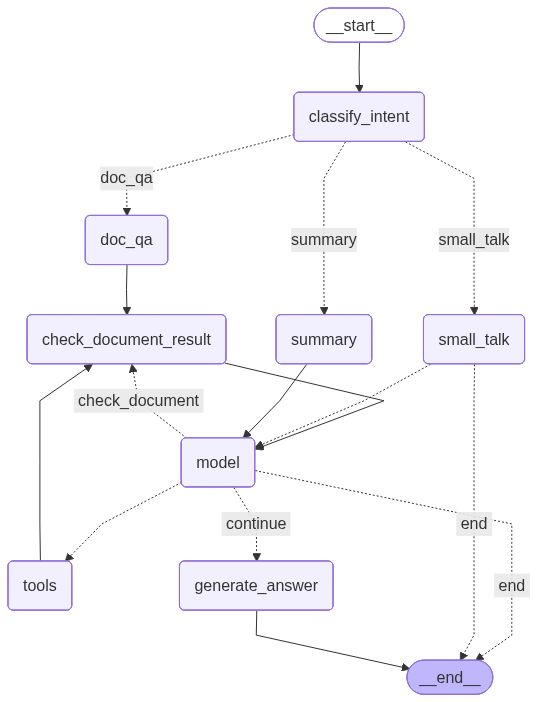


그래프 이미지가 위에 표시되었습니다.


In [11]:
print("=== ASCII 그래프 ===")
app.get_graph().print_ascii()

print("\n=== Mermaid 다이어그램 ===")
mermaid_code = app.get_graph().draw_mermaid()

import re
mermaid_code = re.sub(
    r'classify_intent\s*-\.->\s*doc_qa;',
    'classify_intent -. "doc_qa" .-> doc_qa;',
    mermaid_code
)
mermaid_code = re.sub(
    r'classify_intent\s*-\.->\s*summary;',
    'classify_intent -. "summary" .-> summary;',
    mermaid_code
)
mermaid_code = re.sub(
    r'classify_intent\s*-\.->\s*small_talk;',
    'classify_intent -. "small_talk" .-> small_talk;',
    mermaid_code
)

print(mermaid_code)

try:
    from IPython.display import Image, display, HTML
    import base64
    import urllib.parse
    import requests
    
    def mermaid_to_image(mermaid_code: str):
        try:
            encoded = base64.urlsafe_b64encode(mermaid_code.encode()).decode().rstrip('=')
            image_url = f"https://mermaid.ink/img/{encoded}"
            response = requests.get(image_url, timeout=10)
            if response.status_code == 200:
                return Image(data=response.content)
            else:
                return None
        except Exception as e:
            print(f"이미지 생성 오류: {e}")
            return None
    
    image = mermaid_to_image(mermaid_code)
    if image:
        display(image)
        print("\n그래프 이미지가 위에 표시되었습니다.")
    else:
        print("\n온라인 Mermaid 에디터에 다음 코드를 복사하세요:")
        print("  https://mermaid.live/")
        print("\n또는 다음 HTML을 브라우저에서 열어보세요:")
        html_content = f"""<!DOCTYPE html>
<html>
<head>
    <script src="https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.min.js"></script>
</head>
<body>
    <div class="mermaid">
{mermaid_code}
    </div>
    <script>
        mermaid.initialize({{ startOnLoad: true }});
    </script>
</body>
</html>"""
        display(HTML(f'<a href="data:text/html;charset=utf-8,{urllib.parse.quote(html_content)}" download="graph.html">그래프 HTML 다운로드</a>'))
        
except ImportError:
    print("\nIPython이 설치되지 않았습니다.")
except Exception as e:
    print(f"\n이미지 표시 중 오류 발생: {e}")
    print("\n온라인 Mermaid 에디터에 다음 코드를 복사하세요:")
    print("  https://mermaid.live/")


In [ ]:
def run_query(query: str, thread_id: str = "test-user-1", show_details: bool = True):
    config = {"configurable": {"thread_id": thread_id}}
    
    initial_state = {
        "query": query,
        "messages": [],
        "intent": "",
        "context": "",
        "iteration_count": 0,
        "max_iterations": 3,
        "final_answer": "",
        "intent_history": []
    }
    
    result = app.invoke(initial_state, config=config)
    
    answer = result.get("final_answer", "")
    if not answer:
        messages = result.get("messages", [])
        if messages:
            last_msg = messages[-1]
            if isinstance(last_msg, AIMessage):
                answer = last_msg.content
            else:
                answer = str(last_msg)
        else:
            answer = "답변을 생성할 수 없습니다."
    
    intent = result.get("intent", "UNKNOWN")
    messages = result.get("messages", [])
    
    if show_details:
        print(f"\n[질문] {query}")
        print(f"[의도: {intent}]")
        
        tool_calls = []
        tool_call_count = {}
        for msg in messages:
            if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call.get('name', 'unknown')
                    tool_args = tool_call.get('args', {})
                    tool_calls.append(f"  ✓ {tool_name}({tool_args})")
                    tool_call_count[tool_name] = tool_call_count.get(tool_name, 0) + 1
        
        for msg in messages:
            if isinstance(msg, ToolMessage):
                tool_name = msg.name
                if tool_name not in tool_call_count:
                    tool_calls.append(f"  ✓ {tool_name}(자동 실행)")
                    tool_call_count[tool_name] = 1
        
        if result.get("context") and "document_search" not in tool_call_count:
            tool_calls.append(f"  ✓ document_search(자동 실행)")
            tool_call_count["document_search"] = 1
        
        if tool_calls:
            print(f"\n[사용된 도구] (총 {len(tool_calls)}회)")
            for tool_call in tool_calls:
                print(tool_call)
            if len(tool_call_count) > 1:
                print(f"\n도구별 호출 횟수: {dict(tool_call_count)}")
        
        document_search_results = []
        tool_results = []
        for msg in messages:
            if isinstance(msg, ToolMessage):
                if msg.name == "document_search":
                    document_search_results.append(msg.content)
                else:
                    tool_results.append(f"[{msg.name}] {msg.content[:200]}...")
        
        if not document_search_results and result.get("context"):
            document_search_results.append(result.get("context"))
        
        if document_search_results:
            print(f"\n[문서 검색 결과] (총 {len(document_search_results)}개)")
            for i, doc_result in enumerate(document_search_results, 1):
                print(f"\n--- 문서 {i} ---")
                print(doc_result[:1000])
                if len(doc_result) > 1000:
                    print(f"... (총 {len(doc_result)}자)")
        
        if tool_results:
            print(f"\n[기타 도구 실행 결과]")
            for tool_result in tool_results:
                print(tool_result)
        
        if intent in ["DOC_QA", "SUMMARY"] and result.get("context"):
            print(f"\n[참고 문서 컨텍스트]\n{result['context'][:500]}...")
        
        if document_search_results or tool_results or (intent in ["DOC_QA", "SUMMARY"] and result.get("context")):
            print(f"\n{'='*60}")
    
    print(f"\n[답변]\n{answer}")
    
    return result

thread_id = "test-user-1"

while True:
    q = input("\n질문: ").strip()
    
    if not q:
        continue
    
    if q.lower() in ["exit", "quit"]:
        print("종료합니다.")
        break
    
    run_query(q, thread_id)


[DEBUG] check_document_result_node: 실행 시작
[DEBUG] check_document_result_node: query=서울 날씨 알려줘, intent=SMALL_TALK, messages 개수=4
[DEBUG] check_document_result_node: DOC_QA가 아니므로 스킵
[DEBUG] check_document_result_node: 실행 시작
[DEBUG] check_document_result_node: query=서울 날씨 알려줘, intent=SMALL_TALK, messages 개수=6
[DEBUG] check_document_result_node: DOC_QA가 아니므로 스킵

[질문] 서울 날씨 알려줘
[의도: SMALL_TALK]

[사용된 도구] (총 2회)
  ✓ weather({'city': '서울'})
  ✓ weather({'city': 'Seoul'})

[기타 도구 실행 결과]
[weather] 오류: 404 Client Error: Not Found for url: http://api.openweathermap.org/data/2.5/weather?q=%EC%84%9C%EC%9A%B8&appid=9ec7874bba26eb7c187fd1d5fbb8d0b0&units=metric&lang=kr...
[weather] 도시: Seoul
온도: -2.24°C
설명: 맑음
습도: 59%
풍속: 1.03 m/s...


[답변]
서울의 현재 날씨는 다음과 같습니다:

- **온도:** -2.24°C
- **설명:** 맑음
- **습도:** 59%
- **풍속:** 1.03 m/s

추운 날씨에 외출할 때는 따뜻하게 입으세요!
[DEBUG] doc_qa_node: 실행 시작
[DEBUG] doc_qa_node: query=테슬라 실적 설명해줘 2025년, intent=DOC_QA, messages 개수=7
[DEBUG] doc_qa_node: document_search 실행
[DEBUG] do